<a href="https://colab.research.google.com/github/povstenko/UAV-navigation/blob/main/uav_nav_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %cd /content/drive/MyDrive/IT STEP University/uav-nav/
# !pip install earthengine-api

https://developers.google.com/earth-engine/guides/auth

In [2]:
import ee
import folium

ee.Authenticate()

ee.Initialize(project='ee-povstenko')

region = ee.Geometry.Rectangle([24.148007, 49.80144, 24.149381, 49.80234])

region_coords = [24.1580833, 49.8014167]
region = ee.Geometry.Point(region_coords).buffer(1000)

sentinel = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterDate("2024-01-01", "2024-12-31") \
    .filterBounds(region) \
    .sort("CLOUDY_PIXEL_PERCENTAGE", True) \
    .first()

# sentinel = sentinel.clip(region)

rgb = sentinel.visualize(
    bands=['B4', 'B3', 'B2'],
    min=0,
    max=3000
)

map = folium.Map(location=[region_coords[1], region_coords[0]], zoom_start=15)
map_id_dict = ee.Image(rgb).getMapId()
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Sentinel-2 RGB'
).add_to(map)


folium.LayerControl().add_to(map)

map

In [101]:
!pip install rasterio
!pip install matplotlib
!pip install splitraster
!pip install GDAl
!pip install tensorflow
!pip install imgaug

In [81]:
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from splitraster import geo
import os
import pandas as pd

tiff_path = "sample.tif"
output_dir = "tiles"

# Data Preparation



## Split image to Tiles


### Split to tiles using Splitraser

In [5]:
crop_size = 256
repetition_rate = 0.5
overwrite = True

n = geo.split_image(tiff_path, output_dir, crop_size, repetition_rate=repetition_rate, overwrite=overwrite)

Input Image File Shape (D, H, W):(3, 601, 601)
crop_size=256, stride=128
Padding Image File Shape (D, H, W):(3, 640, 640)


Generating: 100%|██████████| 16/16 [00:00<00:00, 258.42img/s]


In [70]:
# create zip
#!zip -r tiles_splitracer.zip tiles/
%rm -r tiles/*

### Split to tiles using GDAL

In [134]:
ds = gdal.Open(tiff_path)
gt = ds.GetGeoTransform()
print(gt)

pr = ds.GetProjection()
print(pr)

#get coordinates of upper left corner
xmin = gt[0]
ymax = gt[3]
res = gt[1]

#determine total length of raster
xlen = res * ds.RasterXSize
ylen = res * ds.RasterYSize

#number of tiles in x and y direction
xdiv = 5
ydiv = 5

#size of a single tile
xsize = xlen/xdiv
ysize = ylen/ydiv

#create lists of x and y coordinates
xsteps = [xmin + xsize * i for i in range(xdiv+1)]
ysteps = [ymax - ysize * i for i in range(ydiv+1)]

# init dataframe with class data
# Class is the folder name (tile{i}{j})
df_classes = pd.DataFrame(columns=['i', 'j', 'class_label', 'folder', 'tiff_file', 'xmin', 'xmax', 'ymin', 'ymax'])

#loop over min and max x and y coordinates
for i in range(xdiv):
    for j in range(ydiv):
        xmin = xsteps[i]
        xmax = xsteps[i+1]
        ymax = ysteps[j]
        ymin = ysteps[j+1]

        folder_path = "tiles/tile"+str(i)+str(j)+'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        tiff_file_path = folder_path+str(i)+str(j)+".tif"

        df_classes = pd.concat([pd.DataFrame([[i, j, 'tile'+str(i)+str(j), folder_path, tiff_file_path, xmin, xmax, ymin, ymax]], columns=df_classes.columns), df_classes], ignore_index=True)

        gdal.Warp(folder_path+str(i)+str(j)+".tif", ds,
                  outputBounds = (xmin, ymin, xmax, ymax), dstNodata = -9999)

df_classes.style

(594524.0, 10.0, 0.0, 5786626.0, 0.0, -10.0)
PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]


<ipython-input-134-8981ee34c82c>:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_classes = pd.concat([pd.DataFrame([[i, j, 'tile'+str(i)+str(j), folder_path, tiff_file_path, xmin, xmax, ymin, ymax]], columns=df_classes.columns), df_classes], ignore_index=True)


,i,j,class_label,folder,tiff_file,xmin,xmax,ymin,ymax
0,4,4,tile44,tiles/tile44/,tiles/tile44/44.tif,599332.000000,600534.000000,5780616.000000,5781818.000000
1,4,3,tile43,tiles/tile43/,tiles/tile43/43.tif,599332.000000,600534.000000,5781818.000000,5783020.000000
2,4,2,tile42,tiles/tile42/,tiles/tile42/42.tif,599332.000000,600534.000000,5783020.000000,5784222.000000
3,4,1,tile41,tiles/tile41/,tiles/tile41/41.tif,599332.000000,600534.000000,5784222.000000,5785424.000000
4,4,0,tile40,tiles/tile40/,tiles/tile40/40.tif,599332.000000,600534.000000,5785424.000000,5786626.000000
5,3,4,tile34,tiles/tile34/,tiles/tile34/34.tif,598130.000000,599332.000000,5780616.000000,5781818.000000
6,3,3,tile33,tiles/tile33/,tiles/tile33/33.tif,598130.000000,599332.000000,5781818.000000,5783020.000000
7,3,2,tile32,tiles/tile32/,tiles/tile32/32.tif,598130.000000,599332.000000,5783020.000000,5784222.000000
8,3,1,tile31,tiles/tile31/,tiles/tile31/31.tif,598130.000000,599332.000000,5784222.000000,5785424.000000
9,3,0,tile30,tiles/tile30/,tiles/tile30/30.tif,598130.000000,599332.000000,5785424.000000,5786626.000000


In [135]:
# create zip
!zip -r tiles_gdal.zip tiles/

updating: tiles/ (stored 0%)
  adding: tiles/tile34/ (stored 0%)
  adding: tiles/tile34/34_21.png (deflated 0%)
  adding: tiles/tile34/34_17.png (deflated 0%)
  adding: tiles/tile34/34_29.png (deflated 1%)
  adding: tiles/tile34/34_2.png (stored 0%)
  adding: tiles/tile34/34_48.png (deflated 0%)
  adding: tiles/tile34/34_31.png (deflated 3%)
  adding: tiles/tile34/34_18.png (deflated 0%)
  adding: tiles/tile34/34_22.png (stored 0%)
  adding: tiles/tile34/34_46.png (deflated 0%)
  adding: tiles/tile34/34_35.png (deflated 0%)
  adding: tiles/tile34/34_41.png (deflated 0%)
  adding: tiles/tile34/34_0.png (deflated 0%)
  adding: tiles/tile34/34_39.png (deflated 0%)
  adding: tiles/tile34/34_40.png (stored 0%)
  adding: tiles/tile34/34_6.png (stored 0%)
  adding: tiles/tile34/34_16.png (deflated 0%)
  adding: tiles/tile34/34_20.png (deflated 1%)
  adding: tiles/tile34/34_15.png (stored 0%)
  adding: tiles/tile34/34_19.png (deflated 0%)
  adding: tiles/tile34/34_3.png (deflated 0%)
  adding:

 Preview of tiles:

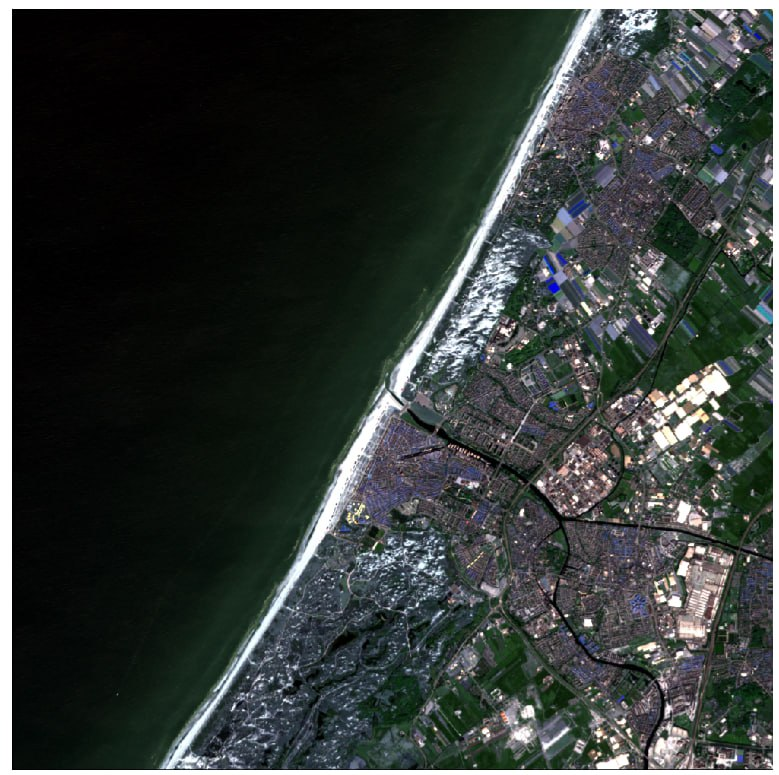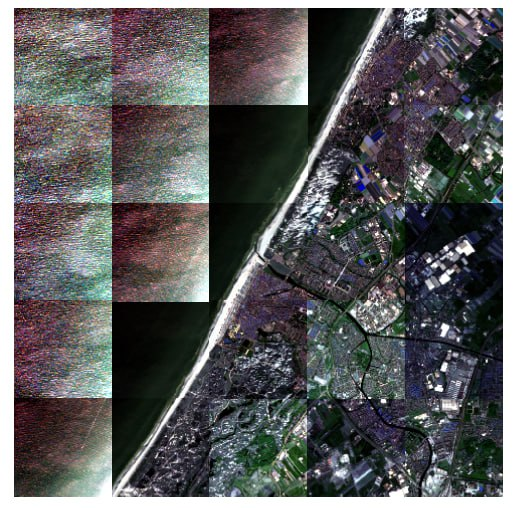

## Visualizing GeoTiff images


### Displaying one band

3


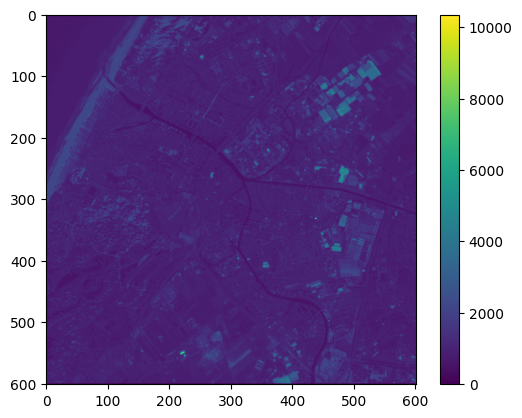

In [136]:
print(ds.RasterCount)

red_band = ds.GetRasterBand(1).ReadAsArray()
green_band = ds.GetRasterBand(3).ReadAsArray()
blue_band = ds.GetRasterBand(2).ReadAsArray()
rgb = np.dstack((red_band,
                 green_band,
                 blue_band))

plt.imshow(blue_band)
plt.colorbar()
plt.show()

### Bitmask

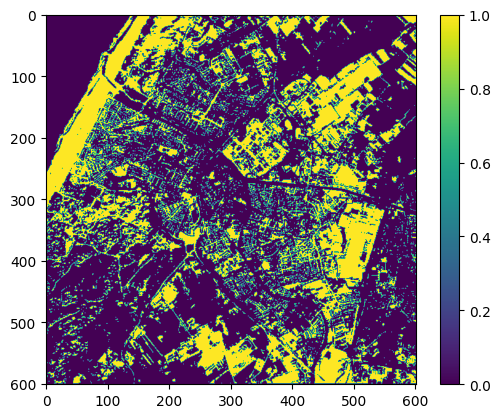

In [137]:
binmask = np.where((blue_band >= np.mean(blue_band)), 1, 0)

plt.figure()
plt.imshow(binmask)
plt.colorbar()
plt.show()

### Minimum and Maximum normalization

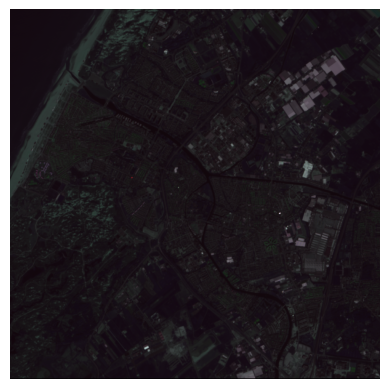

In [138]:
def scale_min_max(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

rgb_min_max_normalized = np.dstack((scale_min_max(red_band),
                            scale_min_max(green_band),
                            scale_min_max(blue_band)))

plt.imshow(rgb_min_max_normalized)
plt.axis('off')
plt.show()

### Standard Deviation scale

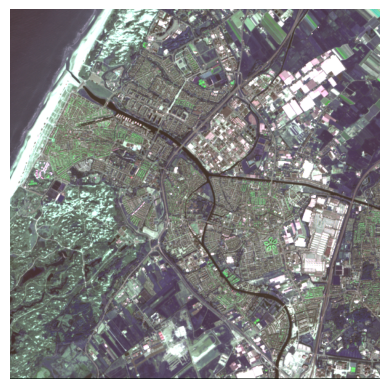

In [139]:
def scale_Std(array):
    return((array - (np.nanmean(array)-np.nanstd(array)*2))/((np.nanmean(array)+np.nanstd(array)*2) - (np.nanmean(array)-np.nanstd(array)*2)))

rgb_std_normalized = np.dstack((scale_Std(red_band),
                            scale_Std(green_band),
                            scale_Std(blue_band)))

plt.imshow(rgb_std_normalized)
plt.axis('off')
plt.show()

### Cumulative Count Cut Normalization

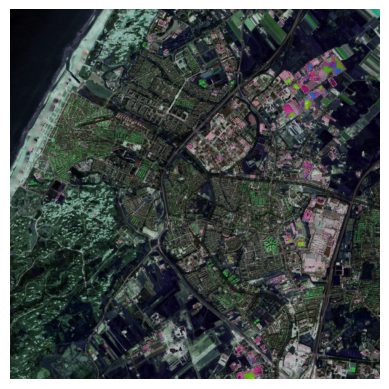

In [140]:
def scale_CCC(array):
    return (array - np.nanpercentile(array,2)) / (np.nanpercentile(array,98) - np.nanpercentile(array,2))

def get_rgb_tiff(ds, inpaint_treshold=200):
    red_band = ds.GetRasterBand(1).ReadAsArray()
    green_band = ds.GetRasterBand(3).ReadAsArray()
    blue_band = ds.GetRasterBand(2).ReadAsArray()

    arr = np.dstack((scale_CCC(red_band),
                            scale_CCC(green_band),
                            scale_CCC(blue_band)))
    arr = (arr*255).astype('uint8')

    # Create a mask where any channel exceeds the threshold
    mask = (arr[:, :, 0] > inpaint_treshold) | (arr[:, :, 1] > inpaint_treshold) | (arr[:, :, 2] > inpaint_treshold)

    # Convert mask to uint8 format for OpenCV (0 or 255)
    mask_uint8 = mask.astype(np.uint8) * 255

    # Apply inpainting using the Telea method
    arr = cv2.inpaint(arr, mask_uint8, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return arr

plt.imshow(get_rgb_tiff(ds))
plt.axis('off')
plt.show()

## Check of file splitting

Merge all tiles into one GeoTiff plot and check if all tiles are well positioned

In [141]:
import glob
file_list = glob.glob('tiles/tile[0-9][0-9]/[0-9][0-9].tif')
file_list

['tiles/tile34/34.tif',
 'tiles/tile03/03.tif',
 'tiles/tile41/41.tif',
 'tiles/tile01/01.tif',
 'tiles/tile23/23.tif',
 'tiles/tile12/12.tif',
 'tiles/tile14/14.tif',
 'tiles/tile00/00.tif',
 'tiles/tile42/42.tif',
 'tiles/tile44/44.tif',
 'tiles/tile10/10.tif',
 'tiles/tile13/13.tif',
 'tiles/tile04/04.tif',
 'tiles/tile33/33.tif',
 'tiles/tile30/30.tif',
 'tiles/tile21/21.tif',
 'tiles/tile43/43.tif',
 'tiles/tile02/02.tif',
 'tiles/tile32/32.tif',
 'tiles/tile40/40.tif',
 'tiles/tile20/20.tif',
 'tiles/tile31/31.tif',
 'tiles/tile24/24.tif',
 'tiles/tile22/22.tif',
 'tiles/tile11/11.tif']

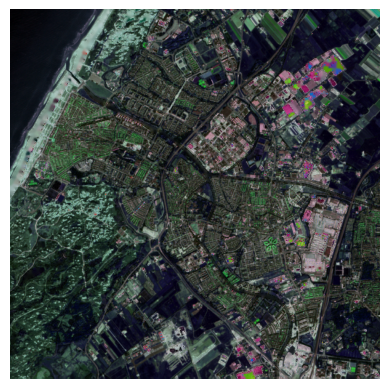

In [142]:
vrt = gdal.BuildVRT('merged.vrt', file_list)
gdal.Translate('merged.tif', vrt, xRes= 10, yRes= -10)
vrt = None # close dataset

ds = gdal.Open('merged.tif') # load new file

plt.imshow(get_rgb_tiff(ds))
plt.axis('off')
plt.show()

показати координати кожного тайлу. в масиві і на мапі точками

## Data Augmentation

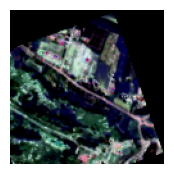

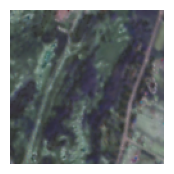

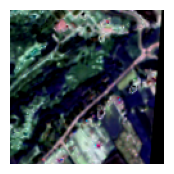

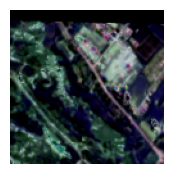

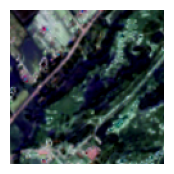

In [143]:
import imgaug.augmenters as iaa
import cv2

augmentation = iaa.Sequential([
    # flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),

    # rotate + scale
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-30, 30),
        scale=(0.8, 1.5),
        shear=(-8, 8)
    ),

    # multiply
    iaa.Multiply((0.8, 1.2), per_channel=0.2),

    # contrast
    iaa.LinearContrast((0.5, 1.5)),

    # blur
    iaa.Sometimes(0.5, iaa.GaussianBlur((0.0, 1.5)))
])

img = cv2.imread('tiles/tile13/13.png')


# preview of augmented data
for i in range(5):
    augmented = augmentation(images = [img])
    for aug in augmented:
        plt.figure(figsize=(2,2))
        plt.imshow(aug)
        plt.axis('off')
        plt.show()

In [144]:
# for each class generate augmented data
for index, row in df_classes.iterrows():
    # open tif
    ds = gdal.Open(row['tiff_file'])
    arr = get_rgb_tiff(ds)

    # save as png
    cv2.imwrite(row['folder']+str(row['i'])+str(row['j'])+'.png', arr)

    # add 49 augmented images per class
    for i in range(49):
        augmented = augmentation(images = [arr])
        for aug in augmented:
            aug_file_path = row['folder']+str(row['i'])+str(row['j'])+'_'+str(i)+'.png'

            cv2.imwrite(aug_file_path, aug)

            print(aug_file_path)
            # plt.figure(figsize=(1,1))
            # plt.imshow(aug)
            # plt.axis('off')
            # plt.show()

    # close file
    ds = None

tiles/tile44/44_0.png
tiles/tile44/44_1.png
tiles/tile44/44_2.png
tiles/tile44/44_3.png
tiles/tile44/44_4.png
tiles/tile44/44_5.png
tiles/tile44/44_6.png
tiles/tile44/44_7.png
tiles/tile44/44_8.png
tiles/tile44/44_9.png
tiles/tile44/44_10.png
tiles/tile44/44_11.png
tiles/tile44/44_12.png
tiles/tile44/44_13.png
tiles/tile44/44_14.png
tiles/tile44/44_15.png
tiles/tile44/44_16.png
tiles/tile44/44_17.png
tiles/tile44/44_18.png
tiles/tile44/44_19.png
tiles/tile44/44_20.png
tiles/tile44/44_21.png
tiles/tile44/44_22.png
tiles/tile44/44_23.png
tiles/tile44/44_24.png
tiles/tile44/44_25.png
tiles/tile44/44_26.png
tiles/tile44/44_27.png
tiles/tile44/44_28.png
tiles/tile44/44_29.png
tiles/tile44/44_30.png
tiles/tile44/44_31.png
tiles/tile44/44_32.png
tiles/tile44/44_33.png
tiles/tile44/44_34.png
tiles/tile44/44_35.png
tiles/tile44/44_36.png
tiles/tile44/44_37.png
tiles/tile44/44_38.png
tiles/tile44/44_39.png
tiles/tile44/44_40.png
tiles/tile44/44_41.png
tiles/tile44/44_42.png
tiles/tile44/44_43.pn

# Dataset split

In [148]:
from sklearn.model_selection import train_test_split

df_classes.head()
# # Split into training and testing sets
# train_df, test_df = train_test_split(df_classes, test_size=0.2, stratify=df_classes["class_label"], random_state=42)

,i,j,class_label,folder,tiff_file,xmin,xmax,ymin,ymax
0,4,4,tile44,tiles/tile44/,tiles/tile44/44.tif,599332.0,600534.0,5780616.0,5781818.0
1,4,3,tile43,tiles/tile43/,tiles/tile43/43.tif,599332.0,600534.0,5781818.0,5783020.0
2,4,2,tile42,tiles/tile42/,tiles/tile42/42.tif,599332.0,600534.0,5783020.0,5784222.0
3,4,1,tile41,tiles/tile41/,tiles/tile41/41.tif,599332.0,600534.0,5784222.0,5785424.0
4,4,0,tile40,tiles/tile40/,tiles/tile40/40.tif,599332.0,600534.0,5785424.0,5786626.0


In [169]:
data = []

# loop the directory and collect file paths with labels
for root, dirs, files in os.walk(output_dir+'/'):
    for file in files:
        if file.endswith(".png"):  # Only consider PNG images
            class_label = os.path.basename(root)  # Class is the folder name (tile{i}{j})
            file_path = os.path.join(root, file)
            data.append((file_path, class_label))

# Convert to a dataframe
df = pd.DataFrame(data, columns=["image_path", "class_label"])
df.head()

,image_path,class_label
0,tiles/tile34/34_21.png,tile34
1,tiles/tile34/34_17.png,tile34
2,tiles/tile34/34_29.png,tile34
3,tiles/tile34/34_2.png,tile34
4,tiles/tile34/34_48.png,tile34


In [173]:
df_merged = df.merge(df_classes, on='class_label', how='left')
df_merged.head()

,image_path,class_label,i,j,folder,tiff_file,xmin,xmax,ymin,ymax
0,tiles/tile34/34_21.png,tile34,3,4,tiles/tile34/,tiles/tile34/34.tif,598130.0,599332.0,5780616.0,5781818.0
1,tiles/tile34/34_17.png,tile34,3,4,tiles/tile34/,tiles/tile34/34.tif,598130.0,599332.0,5780616.0,5781818.0
2,tiles/tile34/34_29.png,tile34,3,4,tiles/tile34/,tiles/tile34/34.tif,598130.0,599332.0,5780616.0,5781818.0
3,tiles/tile34/34_2.png,tile34,3,4,tiles/tile34/,tiles/tile34/34.tif,598130.0,599332.0,5780616.0,5781818.0
4,tiles/tile34/34_48.png,tile34,3,4,tiles/tile34/,tiles/tile34/34.tif,598130.0,599332.0,5780616.0,5781818.0


In [174]:
# Split into training and testing sets
train_df, test_df = train_test_split(df_merged, test_size=0.2, stratify=df_merged["class_label"], random_state=42)

train_df.describe()

,xmin,xmax,ymin,ymax
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,596928.000000,598130.000000,5.783020e+06,5.784222e+06
std,1700.735282,1700.735282,1.700735e+03,1.700735e+03
min,594524.000000,595726.000000,5.780616e+06,5.781818e+06
25%,595726.000000,596928.000000,5.781818e+06,5.783020e+06
50%,596928.000000,598130.000000,5.783020e+06,5.784222e+06
75%,598130.000000,599332.000000,5.784222e+06,5.785424e+06
max,599332.000000,600534.000000,5.785424e+06,5.786626e+06


In [172]:
test_df.describe()

,xmin,xmax,ymin,ymax
count,250.000000,250.000000,2.500000e+02,2.500000e+02
mean,596928.000000,598130.000000,5.783020e+06,5.784222e+06
std,1703.294705,1703.294705,1.703295e+03,1.703295e+03
min,594524.000000,595726.000000,5.780616e+06,5.781818e+06
25%,595726.000000,596928.000000,5.781818e+06,5.783020e+06
50%,596928.000000,598130.000000,5.783020e+06,5.784222e+06
75%,598130.000000,599332.000000,5.784222e+06,5.785424e+06
max,599332.000000,600534.000000,5.785424e+06,5.786626e+06


## Pre-process image train test dataset

In [187]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, target_size)
    # Normalize pixel values to [0, 1]
    img = img / 255.0
    return img

# Apply preprocessing to train and test sets
train_images = np.array([preprocess_image(path) for path in train_df["image_path"]])
test_images = np.array([preprocess_image(path) for path in test_df["image_path"]])

# Extract labels (class indices) for training and testing
train_labels = train_df["class_label"].factorize()[0]  # Convert class labels to indices
test_labels = test_df["class_label"].factorize()[0]

# Build Model

In [177]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(df_classes), activation='softmax')  # Output layer with one neuron per class
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [178]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=10,
    batch_size=32
)

In [192]:
# Predict class indices for test images
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


array([17,  3, 13, 15,  1,  0, 10, 10, 14, 10, 21,  3, 17,  8, 15,  7, 23,
       20, 13, 20, 16, 17,  1,  2, 22, 22, 13, 14, 20, 23, 18, 15, 13, 23,
       21, 24,  2,  6,  7, 14,  5, 19,  6, 20, 19,  5, 21, 10, 10, 14,  4,
       22, 20, 22, 22,  7,  7, 19, 23, 20, 19, 14,  5, 10,  3, 12, 13, 13,
       16,  6, 17,  3, 24, 20,  7, 14, 15, 13, 10, 18,  2, 23, 14,  6,  9,
       17, 19, 14,  7, 14, 22,  7, 20, 17, 23, 22, 13, 16, 19, 10,  7, 14,
        0, 12,  7,  4, 13, 23,  9, 24, 13, 14, 13, 13, 22,  8, 10, 23,  6,
       24, 24, 13,  1,  8,  5, 22, 22, 22, 19, 14, 17, 16, 20, 16, 11, 14,
        7, 23, 20, 10,  6,  1, 23, 21,  7, 10, 21, 18, 16,  1, 21, 23, 12,
       18, 24, 10, 18,  8, 23, 19, 22,  9,  5,  3, 15, 16,  6, 10,  5, 21,
       17,  3, 22,  1, 13, 18, 19,  8, 21, 10, 18, 14,  5,  5,  9, 24,  7,
       18,  0, 20, 18,  7,  1, 16,  4, 15, 22,  3, 17, 22, 19,  3,  5, 14,
        5, 10, 13, 19,  3, 21, 19, 24, 12, 17, 17,  0, 24, 10, 22,  6, 22,
       19,  8, 13,  3,  6